In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import kurtosis
from catboost import CatBoostRegressor, Pool, cv
from seaborn import histplot
from matplotlib import pyplot as plt

In [312]:
# Generate mode one hot encoding features
def generate_mode_ohe(data: pd.DataFrame) -> pd.DataFrame:

    result = pd.DataFrame()

    result['Mode1'] = (data.Mode == 1) * 1
    result['Mode2'] = (data.Mode == 2) * 1
    result['Mode3'] = (data.Mode == 3) * 1
    result['Mode4'] = (data.Mode == 4) * 1

    return result


# Generate uptime features
def generate_uptime(data: pd.DataFrame) -> pd.DataFrame:

    result = pd.DataFrame()
    
    result['Mode1_uptime'] = np.nan
    result['Mode2_uptime'] = np.nan
    result['Mode3_uptime'] = np.nan
    result['Mode4_uptime'] = np.nan
    result['Cycle_uptime'] = np.nan

    mode1_time = 0
    mode2_time = 0
    mode3_time = 0
    mode4_time = 0
    cycle_time = 0
    current_mode1 = 0
    current_mode2 = 0
    current_mode3 = 0
    current_mode4 = 0

    for index, row in data.iterrows():
        mode1_time += 1
        mode2_time += 1
        mode3_time += 1
        mode4_time += 1
        cycle_time += 1

        if current_mode1 == 0 and row['Mode1'] == 1:
            mode1_time = 1
            cycle_time = 1
        if current_mode2 == 0 and row['Mode2'] == 1:
            mode2_time = 1
            cycle_time = 1
        if current_mode3 == 0 and row['Mode3'] == 1:
            mode3_time = 1
            cycle_time = 1
        if current_mode4 == 0 and row['Mode4'] == 1:
            mode4_time = 1
            cycle_time = 1

        current_mode1 = row['Mode1']
        current_mode2 = row['Mode2']
        current_mode3 = row['Mode3']
        current_mode4 = row['Mode4']

        result.loc[index, 'Mode1_uptime'] = mode1_time
        result.loc[index, 'Mode2_uptime'] = mode2_time
        result.loc[index, 'Mode3_uptime'] = mode3_time
        result.loc[index, 'Mode4_uptime'] = mode4_time
        result.loc[index, 'Cycle_uptime'] = cycle_time
        
        result['Cycle_uptime1'] = result['Cycle_uptime']
        result['Cycle_uptime2'] = result['Cycle_uptime']
        
    return result


def generate_ema(data: pd.Series, periods: np.array, columns: list) -> pd.DataFrame:
    alphas = 2 / (periods + 1)

    # Memory allocation for resulting values
    result_ema = np.ndarray((data.shape[0], len(alphas)), dtype=float)

    # Fill buffer vectors
    ema_buffer = np.ones((len(alphas),), dtype=float) * data.iloc[0]
    result_ema[0] = ema_buffer


    # Calculation of EMA, DMA, TMA, QMA
    for i in range(1, data.shape[0]):
        ema_buffer = ema_buffer * (1 - alphas) + alphas * data.iloc[i]
        result_ema[i] = ema_buffer


    # Convert result into pandas DaraFrame
    return pd.DataFrame(result_ema, index=data.index, columns=columns)

def generate_lags(data: pd.DataFrame) -> pd.DataFrame:

    result = pd.DataFrame()

    result['error1_lag1'] = data['error1_values'].shift(1, fill_value=data['error1_values'].iloc[0])
    result['error2_lag1'] = data['error2_values'].shift(1, fill_value=data['error2_values'].iloc[0])
    result['error3_lag1'] = data['error3_values'].shift(1, fill_value=data['error3_values'].iloc[0])
    
    result['error1_diff1'] = result['error1_lag1'] - data['error1_values'].shift(2, fill_value=data['error1_values'].iloc[0])
    result['error2_diff1'] = result['error2_lag1'] - data['error2_values'].shift(2, fill_value=data['error2_values'].iloc[0])
    result['error3_diff1'] = result['error3_lag1'] - data['error3_values'].shift(2, fill_value=data['error3_values'].iloc[0])
    
    result['error1_lag2'] = data['error1_values'].shift(3, fill_value=data['error1_values'].iloc[0])
    result['error2_lag2'] = data['error2_values'].shift(3, fill_value=data['error2_values'].iloc[0])
    result['error3_lag2'] = data['error3_values'].shift(3, fill_value=data['error3_values'].iloc[0])

    return result


In [313]:
row_data = pd.read_csv('errors_data', index_col=0).reset_index(drop=True)
errors_raw_target = pd.read_csv('errors_target', index_col=0).reset_index(drop=True)
errors_data = row_data.drop(['Ai1 min', 'ai1 mean', 'ai1 max', 'Ai2 min', 'ai2 mean', 'ai2 max', 'Ai3 min', 'ai3 mean', 'ai3 max'], 
              axis=1).copy()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

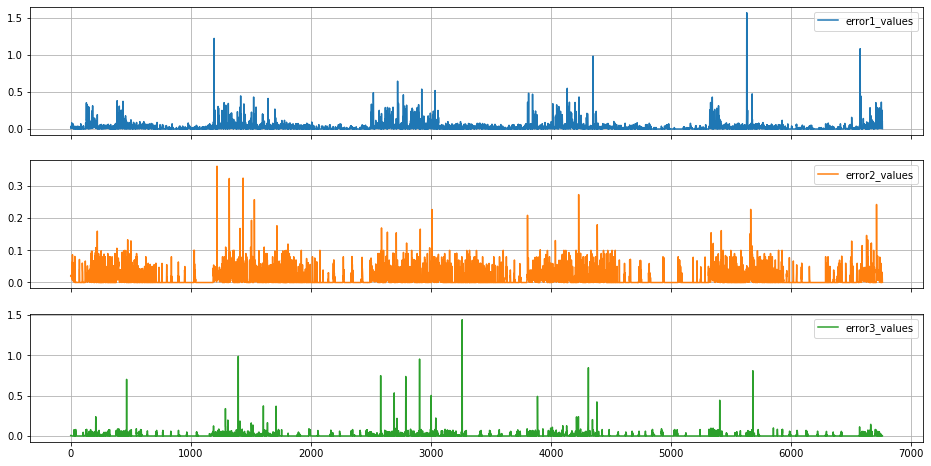

In [314]:
errors_raw_target.abs().plot(figsize=(16, 8), subplots=True, grid=True)

array([<AxesSubplot:>], dtype=object)

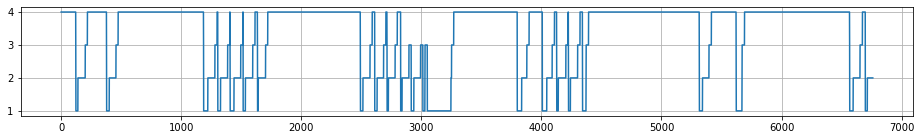

In [315]:
errors_data['Mode'].plot(figsize=(16, 2), subplots=True, grid=True)

In [316]:
errors_data = errors_data.join(generate_mode_ohe(errors_data))
errors_data = errors_data.join(generate_uptime(errors_data))
errors_data = errors_data.join(generate_lags(errors_raw_target))
errors_data.drop(['Mode', 'Mode1_uptime', 'Mode2_uptime', 'Mode3_uptime', 'Mode4_uptime'], axis=1, inplace=True)

errors_target = pd.DataFrame()
errors_target = errors_target.join(generate_ema(errors_raw_target['error1_values'], np.array([1.5]), ['error_ema_1']), how='right')
errors_target = errors_target.join(generate_ema(errors_raw_target['error2_values'], np.array([1.5]), ['error_ema_2']), how='right')
errors_target = errors_target.join(generate_ema(errors_raw_target['error3_values'], np.array([1.5]), ['error_ema_3']), how='right')
errors_target = errors_target.abs()
errors_target['error1_ema_abs'] = np.log(errors_target['error_ema_1']+0.0001) - np.mean(np.log(errors_target['error_ema_1']+0.0001))
errors_target['error2_ema_abs'] = np.log(errors_target['error_ema_2']+0.0001) - np.mean(np.log(errors_target['error_ema_2']+0.0001))
errors_target['error3_ema_abs'] = np.log(errors_target['error_ema_3']+0.0001) - np.mean(np.log(errors_target['error_ema_3']+0.0001))
errors_target = errors_target.join(generate_ema(errors_target['error1_ema_abs'], np.array([8]), ['error_ratio_1']))
errors_target = errors_target.join(generate_ema(errors_target['error2_ema_abs'], np.array([8]), ['error_ratio_2']))
errors_target = errors_target.join(generate_ema(errors_target['error3_ema_abs'], np.array([8]), ['error_ratio_3']))
errors_target.drop(['error1_ema_abs', 'error2_ema_abs', 'error3_ema_abs', 'error_ema_1', 'error_ema_2', 'error_ema_3'], axis=1, inplace=True)


In [317]:
errors_target

,error_ratio_1,error_ratio_2,error_ratio_3
0,1.586190,2.760649,2.314541
1,1.581613,2.769871,2.350753
2,1.368295,2.767550,2.413565
3,1.163210,2.750550,2.433304
4,1.061583,2.720021,2.360158
...,...,...,...
6756,2.346835,0.037496,0.778638
6757,2.191153,0.697581,0.458905
6758,2.284668,1.203871,0.287362
6759,2.436761,0.955790,0.357312


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

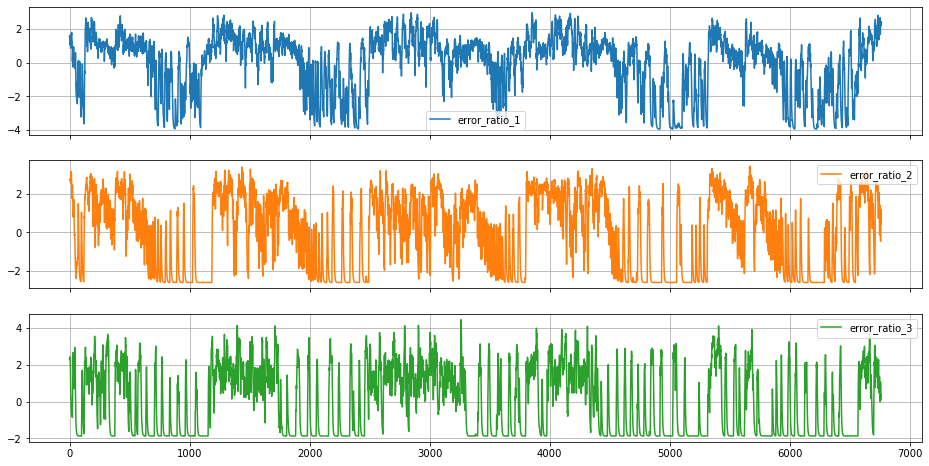

In [318]:
errors_target.plot(figsize=(16, 8), subplots=True, grid=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

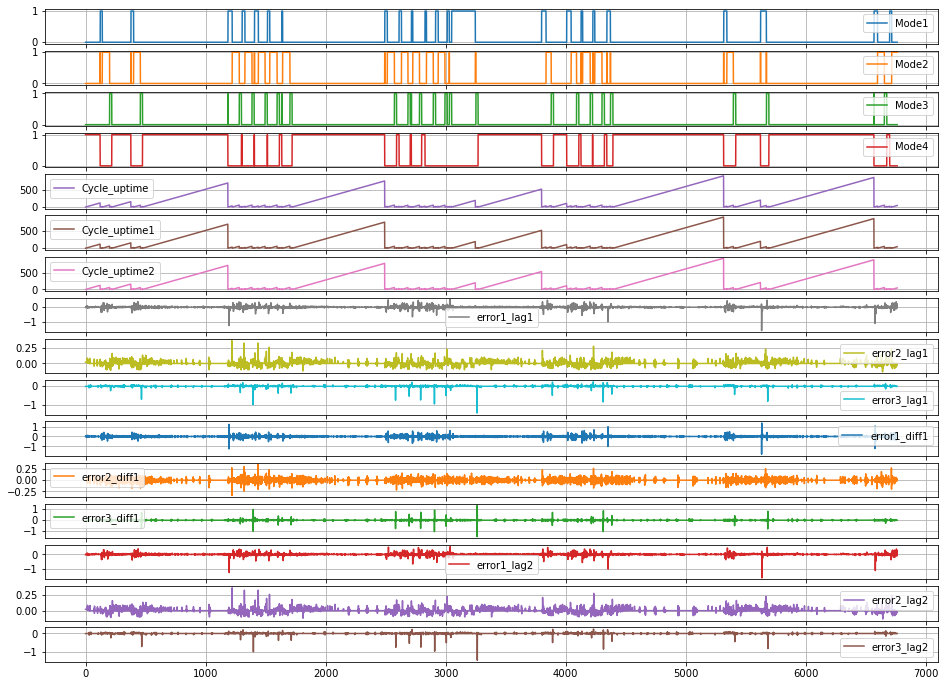

In [319]:
errors_data.plot(figsize=(16, 12), subplots=True, grid=True)

In [320]:
params = {
    'loss_function': 'RMSE',
    'iterations': 500,
    'depth': 5,
    'rsm': 0.7,
    'random_seed': 0,
    'custom_metric': 'R2',
    'learning_rate': 0.05
}

cb_model = CatBoostRegressor(n_estimators=params['iterations'],
                             learning_rate=params['learning_rate'],
                             rsm=params['rsm'],
                             depth=params['depth'],
                             loss_function=params['loss_function'],
                             thread_count=-1,
                             random_seed=0,
                             logging_level='Silent')

cb_temp1_model = cb_model.copy()
cb_temp2_model = cb_model.copy()
cb_temp3_model = cb_model.copy()

In [321]:
print(f'Temp1 Std={np.std(errors_target.values[:, 0]):.4f}°C')
print(f'Temp1 MAD={errors_target.iloc[:, 0].mad():.4f}°C')
cv_data = cv(
    params=params,
    pool=Pool(errors_data, label=errors_target.values[:, 0]),
    fold_count=3, 
    shuffle=False, 
    partition_random_seed=0,
    plot=True, 
    stratified=False, 
    verbose=False
)

n_estimators=np.argmin(cv_data[''.join(['test-', params['loss_function'], '-mean'])])
print(f'Best n_estimators={n_estimators}')
print(''.join([params['loss_function'], f'={cv_data.iloc[n_estimators, 1]:.4f}°C']))
print(f'R^2={cv_data["test-R2-mean"][n_estimators]:.3f}')
cb_temp1_model.set_params(n_estimators=n_estimators)
cb_temp1_model.fit(errors_data, errors_target.values[:, 0])

feature_importance = cb_temp1_model.get_feature_importance(Pool(errors_data, label=errors_target.values[:, 0]))
for item in zip(errors_data.columns.tolist(), feature_importance):
    print(item)

Temp1 Std=1.7028°C
Temp1 MAD=1.3764°C


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best n_estimators=499
RMSE=0.5485°C
R^2=0.881
('Mode1', 0.42545162296646566)
('Mode2', 0.5776527732304197)
('Mode3', 0.11777246435450658)
('Mode4', 0.6809530152858704)
('Cycle_uptime', 5.1120230219216305)
('Cycle_uptime1', 6.41556908705364)
('Cycle_uptime2', 3.219197432439846)
('error1_lag1', 30.69243244327606)
('error2_lag1', 0.4524497472971744)
('error3_lag1', 0.5667270486261136)
('error1_diff1', 22.650975492867165)
('error2_diff1', 0.6992730894108307)
('error3_diff1', 0.39655562566652686)
('error1_lag2', 26.58521884251873)
('error2_lag2', 0.5789595246479159)
('error3_lag2', 0.8287887684370702)


In [322]:
print(f'Temp2 Std={np.std(errors_target.values[:, 1]):.4f}°C')
print(f'Temp2 MAD={errors_target.iloc[:, 1].mad():.4f}°C')
cv_data = cv(
    params=params,
    pool=Pool(errors_data, label=errors_target.values[:, 1]),
    fold_count=3, 
    shuffle=False, 
    partition_random_seed=0,
    plot=True, 
    stratified=False, 
    verbose=False
)

n_estimators=np.argmin(cv_data[''.join(['test-', params['loss_function'], '-mean'])])
print(f'Best n_estimators={n_estimators}')
print(''.join([params['loss_function'], f'={cv_data.iloc[n_estimators, 1]:.4f}°C']))
print(f'R^2={cv_data["test-R2-mean"][n_estimators]:.3f}')
cb_temp2_model.set_params(n_estimators=n_estimators)
cb_temp2_model.fit(errors_data, errors_target.values[:, 1])

feature_importance = cb_temp2_model.get_feature_importance(Pool(errors_data, label=errors_target.values[:, 1]))
for item in zip(errors_data.columns.tolist(), feature_importance):
    print(item)

Temp2 Std=1.9218°C
Temp2 MAD=1.7292°C


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best n_estimators=454
RMSE=0.5911°C
R^2=0.899
('Mode1', 0.16204292778348756)
('Mode2', 0.2609128116715087)
('Mode3', 0.07674442980458118)
('Mode4', 0.9604266285834999)
('Cycle_uptime', 5.088321466000935)
('Cycle_uptime1', 7.714622668593837)
('Cycle_uptime2', 3.583700153742783)
('error1_lag1', 0.4470712200676775)
('error2_lag1', 23.96255482808308)
('error3_lag1', 0.5231708489262223)
('error1_diff1', 0.2748479467938456)
('error2_diff1', 32.51187334111062)
('error3_diff1', 0.4151469344701751)
('error1_lag2', 0.43363840639172213)
('error2_lag2', 23.091365853564177)
('error3_lag2', 0.4935595344118447)


In [323]:
print(f'Temp3 Std={np.std(errors_target.values[:, 2]):.4f}°C')
print(f'Temp3 MAD={errors_target.iloc[:, 2].mad():.4f}°C')
cv_data = cv(
    params=params,
    pool=Pool(errors_data, label=errors_target.values[:, 2]),
    fold_count=3, 
    shuffle=False, 
    partition_random_seed=0,
    plot=True, 
    stratified=False, 
    verbose=False
)

n_estimators=np.argmin(cv_data[''.join(['test-', params['loss_function'], '-mean'])])
print(f'Best n_estimators={n_estimators}')
print(''.join([params['loss_function'], f'={cv_data.iloc[n_estimators, 1]:.4f}°C']))
print(f'R^2={cv_data["test-R2-mean"][n_estimators]:.3f}')
cb_temp3_model.set_params(n_estimators=n_estimators)
cb_temp3_model.fit(errors_data, errors_target.values[:, 2])

feature_importance = cb_temp3_model.get_feature_importance(Pool(errors_data, label=errors_target.values[:, 2]))
for item in zip(errors_data.columns.tolist(), feature_importance):
    print(item)

Temp3 Std=1.8082°C
Temp3 MAD=1.6653°C


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best n_estimators=479
RMSE=0.5148°C
R^2=0.913
('Mode1', 0.33815612952768553)
('Mode2', 0.3737265737450565)
('Mode3', 1.1809006351393214)
('Mode4', 10.377897022716759)
('Cycle_uptime', 2.2023009834190543)
('Cycle_uptime1', 1.414859181279238)
('Cycle_uptime2', 1.265556206494168)
('error1_lag1', 0.22018704051557048)
('error2_lag1', 0.4099972411319649)
('error3_lag1', 17.0733977212101)
('error1_diff1', 0.3309784857598222)
('error2_diff1', 0.31461907594249444)
('error3_diff1', 31.838867186762265)
('error1_lag2', 0.2204474610357784)
('error2_lag2', 0.7184658091371172)
('error3_lag2', 31.719643246183598)


In [324]:
comparative_error1 = np.exp(errors_target.values[:, 0] - cb_temp1_model.predict(errors_data))
comparative_error2 = np.exp(errors_target.values[:, 1] - cb_temp2_model.predict(errors_data))
comparative_error3 = np.exp(errors_target.values[:, 2] - cb_temp3_model.predict(errors_data))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

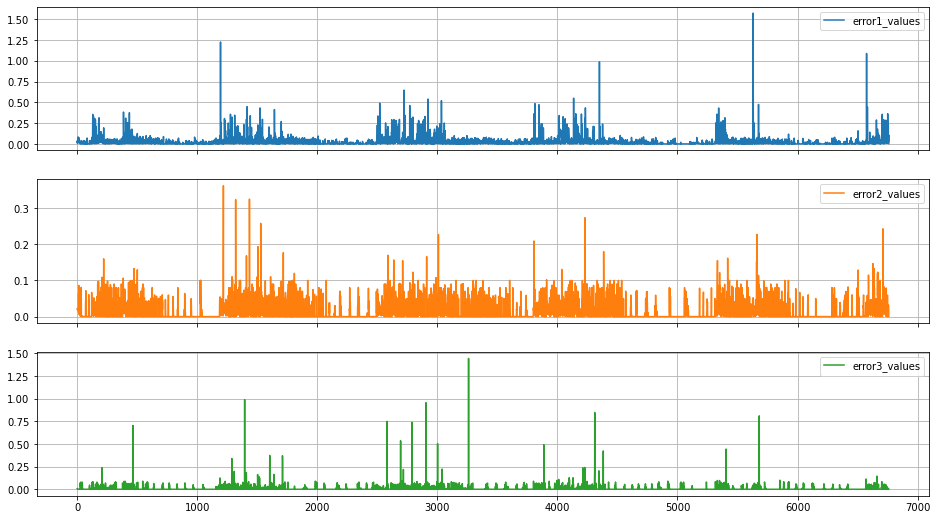

In [325]:
errors_raw_target.abs().plot(figsize=(16, 9), subplots=True, grid=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

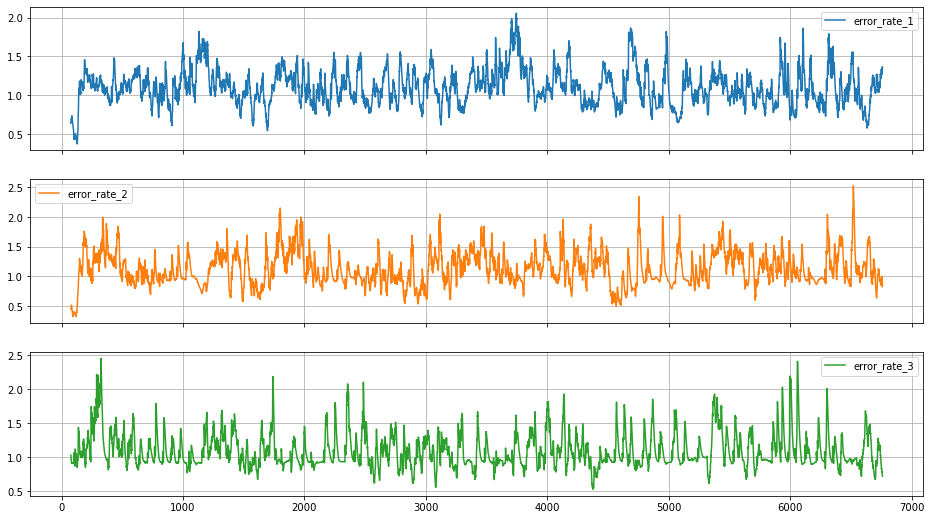

In [326]:
comparative_errors = pd.DataFrame(np.vstack((comparative_error1, comparative_error2, comparative_error3)).T,
                                  columns=['comparative_error1', 'comparative_error2', 'comparative_error3'])
comparative_errors = comparative_errors.join(generate_ema(comparative_errors['comparative_error1'], np.array([20]), ['error_rate_1']))[25:]
comparative_errors = comparative_errors.join(generate_ema(comparative_errors['comparative_error2'], np.array([20]), ['error_rate_2']))[25:]
comparative_errors = comparative_errors.join(generate_ema(comparative_errors['comparative_error3'], np.array([20]), ['error_rate_3']))[25:]
comparative_errors.drop(['comparative_error1', 'comparative_error2', 'comparative_error3'], axis=1, inplace=True)

comparative_errors.plot(figsize=(16, 9), subplots=True, grid=True)

Temp1 Kurtosis=1.21
Temp1 Kurtosis=147.44 - фикс. порог
Max_value/Avg =2.12
Max_value/Avg =57.21 - фикс. порог


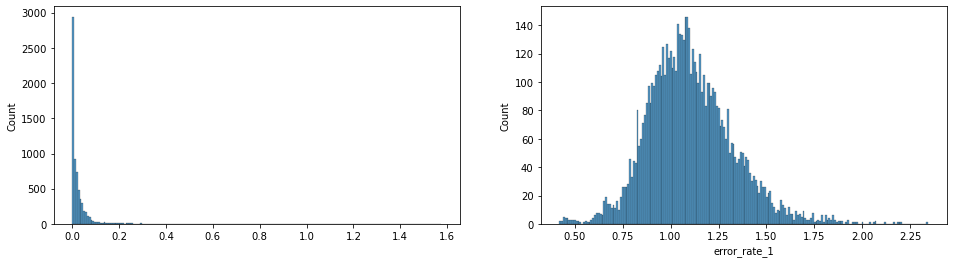

In [309]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 4)
histplot(np.abs(errors_raw_target.values[:, 0]), bins=200, log_scale=False, ax=axes[0])
histplot(comparative_errors.iloc[:, 0], bins=200, log_scale=False, ax=axes[1])
print(f'Temp1 Kurtosis={kurtosis(comparative_errors.iloc[:, 0]):.2f}')
print(f'Temp1 Kurtosis={kurtosis(np.abs(errors_raw_target.values[:, 0])):.2f} - фикс. порог')
print(f'Max_value/Avg ={np.max(comparative_errors.iloc[:, 0])/np.mean(comparative_errors.iloc[:, 0]):.2f}') 
print(f'Max_value/Avg ={np.max(np.abs(errors_raw_target.values[:, 0]))/np.mean(np.abs(errors_raw_target.values[:, 0])):.2f} - фикс. порог')

Temp2 Kurtosis=1.90
Temp2 Kurtosis=22.00 - фикс. порог
Max_value/Avg =2.63
Max_value/Avg =26.95 - фикс. порог


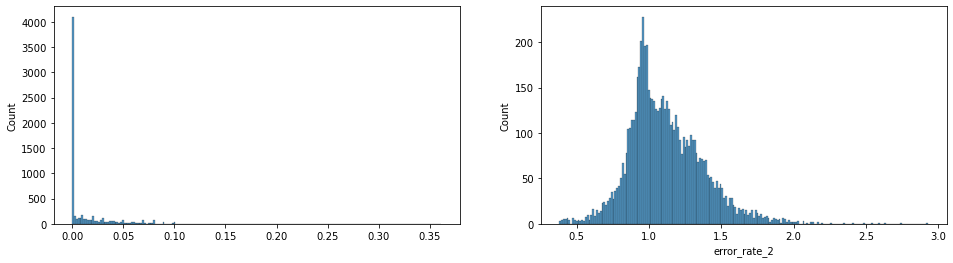

In [310]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 4)
histplot(np.abs(errors_raw_target.values[:, 1]), bins=200, log_scale=False, ax=axes[0])
histplot(comparative_errors.iloc[:, 1], bins=200, log_scale=False, ax=axes[1])
print(f'Temp2 Kurtosis={kurtosis(comparative_errors.iloc[:, 1]):.2f}')
print(f'Temp2 Kurtosis={kurtosis(np.abs(errors_raw_target.values[:, 1])):.2f} - фикс. порог')
print(f'Max_value/Avg ={np.max(comparative_errors.iloc[:, 1])/np.mean(comparative_errors.iloc[:, 1]):.2f}') 
print(f'Max_value/Avg ={np.max(np.abs(errors_raw_target.values[:, 1]))/np.mean(np.abs(errors_raw_target.values[:, 1])):.2f} - фикс. порог')

Temp3 Kurtosis=4.11
Temp3 Kurtosis=462.33 - фикс. порог
Max_value/Avg =2.50
Max_value/Avg =159.69 - фикс. порог


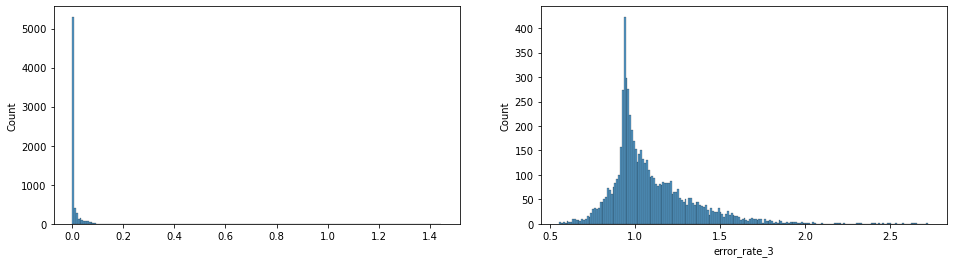

In [311]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 4)
histplot(np.abs(errors_raw_target.values[:, 2]), bins=200, log_scale=False, ax=axes[0])
histplot(comparative_errors.iloc[:, 2], bins=200, log_scale=False, ax=axes[1])
print(f'Temp3 Kurtosis={kurtosis(comparative_errors.iloc[:, 2]):.2f}')
print(f'Temp3 Kurtosis={kurtosis(np.abs(errors_raw_target.values[:, 2])):.2f} - фикс. порог')
print(f'Max_value/Avg ={np.max(comparative_errors.iloc[:, 2])/np.mean(comparative_errors.iloc[:, 2]):.2f}') 
print(f'Max_value/Avg ={np.max(np.abs(errors_raw_target.values[:, 2]))/np.mean(np.abs(errors_raw_target.values[:, 2])):.2f} - фикс. порог')